In [1]:
from rllib.mdp import OptimalGoalPolicy
from rllib.shapeworld import GoalWorld
from sklearn.manifold import MDS
from itertools import combinations
import numpy as np
import pandas as pd
import random
from random import sample, Random
from math import log
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from typing import Sequence, Hashable, TypeVar, Generic, Container, Tuple
import pickle
from collections import defaultdict, Counter, namedtuple
from tqdm import tqdm
from rllib.mdp import MarkovDecisionProcess


## Class definitions

In [2]:

# We want actions to be hashable so that we can use them as dictionary keys for Q-learning later
Action = TypeVar('Action', bound=Hashable)
Shape = namedtuple('Shape',['sides', 'shade', 'texture'])
State = TypeVar('State', bound=Hashable)
Likelihood = TypeVar('Likelihood', float, int)

class GoalSelectionPolicy(Generic[State, Action]):
    def __init__(self, mdp: MarkovDecisionProcess[State, Action]):
        '''Initialize the policy with the MDP.'''
        self.mdp = mdp
        self.state_space = mdp.state_space

    def sample_action(self, rng : Random = random) -> tuple[Action, Likelihood]:
        '''Uses some policy to select which goal to select.'''
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

class OptimalGoalPolicy(GoalSelectionPolicy[State, Action]):
    '''Takes the optimal value function computed from value iteration to select goals.'''

    def __init__(self, mdp: MarkovDecisionProcess[State, Action], value_function: dict[State, float]):
        super().__init__(mdp)
        # we will use the value function from value iteration to select the goal
        self.value_function = value_function
        self.mds = None # multidimensional scaling

    def sample_action(self, rng: random.Random = random) -> tuple[State, float]:
        '''Use softmax to sample a goal state based on the value function.'''
        # Assuming 'actions' here are actually states for goal selection
        states = list(self.value_function.keys())
        state_values = np.array([self.value_function[state] for state in states])

        # Compute softmax probabilities
        exp_values = np.exp(state_values - np.max(state_values))  # for numerical stability
        probabilities = exp_values / np.sum(exp_values)

        # Sample a state based on these probabilities
        selected_state = rng.choices(states, weights=probabilities)[0]

        # Calculate the negative log likelihood of the selected state
        nll = -np.log(probabilities[states.index(selected_state)])

        return (selected_state, nll)
    
    def calc_neg_log_lik(self, state: State) -> float:
        '''Calculate the negative log likelihood of selecting a particular state.

        Parameters:
        state (State): The state for which to calculate the negative log likelihood.

        Returns:
        float: The negative log likelihood of selecting the given state.
        '''
        state_values = np.array([self.value_function[s] for s in self.state_space])
        exp_values = np.exp(state_values - np.max(state_values))
        probabilities = exp_values / np.sum(exp_values)
        return -np.log(probabilities[self.state_space.index(state)])
    
    def calc_neg_log_likelihood_all(self) -> dict[State, float]:
        '''Calculate the log likelihood of all states in the state space.'''
        # get all the value for the states and convert them to probabilities
        state_values = np.array([self.value_function[state] for state in self.state_space])
        exp_values = np.exp(state_values - np.max(state_values))
        probabilities = exp_values / np.sum(exp_values)
        # print(f"Length of probabilities: {len(probabilities)}")
        neg_log_likelihoods = {s: -np.log(probabilities[self.state_space.index(s)]) for s in self.state_space}
        return neg_log_likelihoods
    
    def calc_neg_log_likelihood_all_df(self) -> pd.DataFrame:
        '''Return log lik as a dataframe.'''
        neg_log_likelihood = self.calc_neg_log_likelihood_all()
        return pd.DataFrame(neg_log_likelihood.items(), columns=['State', 'Negative Log Lik'])
    
    def _load_value_functions_all(self, directory):
        """
        Load all value function files from the specified directory.
        
        Note, this is not the same as the value function for choosing goals. 
        These are the results of value iteration for separate goal state.
        This is intended to be used for calculated a distance matrix between states.
        """
        print('Loading value functions from directory:', directory)
        value_functions = {}
        for filename in tqdm(os.listdir(directory), desc='Loading files'):
            if filename.endswith('.pkl'):
                filepath = os.path.join(directory, filename)
                with open(filepath, 'rb') as file:
                    value_function, goal_state = pd.read_pickle(file)
                    adjusted_value_function = {state: value - self.mdp.GOAL_REWARD for state, value in value_function.items()}
                    value_functions[goal_state] = adjusted_value_function
        return value_functions

    def _calc_distance_matrix(self) -> np.ndarray:
        '''Calculate the distance matrix between all states in the state space.'''

        val_funs = self._load_value_functions_all('value-iteration-results')

        # Extract all unique states from the keys of the value functions
        print('Sorting states...')
        states = list(set.union(*[set(vf.keys()) for vf in val_funs.values()]))
        states.sort()  # Ensure consistent order
        num_states = len(states)

        # Initialize the distance matrix with infinity
        distance_matrix = np.full((num_states, num_states), np.inf)

        # Fill in the distance matrix
        for i, state_i in tqdm(enumerate(states), total=len(states), desc="Computing distance matrix"):
            for j, state_j in enumerate(states):
                if state_i in val_funs and state_j in val_funs[state_i]:
                    value = val_funs[state_i][state_j]
                    # larger negative means further from goal, thus abs()
                    distance_matrix[i, j] = abs(value) if value != 0 else np.inf
                    # Goals states have a distance of 0
                    if state_j == state_i:
                        distance_matrix[i, j] = 0

        # Our distance is not symmetric since there are some state transitions that are asymetric
        for i in tqdm(range(num_states), desc="Ensuring symmetry"):
            for j in range(i+1, num_states):  # Only iterate over the upper triangle, excluding the diagonal
                # Take the minimum distance as our measure of similarity
                min_distance = min(abs(distance_matrix[i, j]), abs(distance_matrix[j, i]))
                # Update both entries to ensure symmetry
                distance_matrix[i, j] = distance_matrix[j, i] = min_distance
        return distance_matrix

    def calc_multi_dimensional_scaling(self) -> np.ndarray:
        distance_matrix = self._calc_distance_matrix()
        # Apply MDS
        print('Applying Multi-Dimensional Scaling...')
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        coords = mds.fit_transform(distance_matrix)
        self.mds = coords

    def plot_state_space(self):
        '''Plot the state space in 2D using MDS.'''
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        plt.figure(figsize=(10, 8))
        plt.scatter(self.mds[:, 0], self.mds[:, 1], marker='o')
        for i, coord in enumerate(self.mds):
            plt.text(coord[0], coord[1], str(i), color='red')
        plt.title('ShapeWorld Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

    def plot_state_space_with_likelihood(self, is_dark=False, save=False, filename=None):
        '''Plot the state space in 2D using MDS with the negative log likelihood of each state.'''
        
        # Check to see if the mds has been calculated
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        # Calculate the negative log likelihood of each state
        neg_log_likelihoods = self.calc_neg_log_likelihood_all_df()


        # Set the font properties
        font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
        font_prop = fm.FontProperties(fname=font_path, size=14)

        # set deafult style
        matplotlib.rcdefaults()

        plt.figure(figsize=(10, 8))
        # Sort the coordinates and likelihoods in descending order based on likelihoods
        sorted_indices = np.argsort(neg_log_likelihoods['Negative Log Lik'])[::-1]
        #print(sorted_indices)
        sorted_coords = self.mds[sorted_indices]
        # print(sorted_coords)
        sorted_likelihoods = np.array(neg_log_likelihoods['Negative Log Lik'])[sorted_indices]
        print(sorted_likelihoods)
        # Plot the points with greater likelihoods on top
        plt.scatter(sorted_coords[:, 0], sorted_coords[:, 1], c=sorted_likelihoods, cmap='plasma_r', marker='o', alpha=1, s=70)
        plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
        plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
        plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
        plt.colorbar(label='Negative Log Lik')
        plt.grid(False)  # Remove gridlines

        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
        plt.tight_layout()  # Adjust spacing
        plt.show()

        if save:
            plt.savefig(filename)

    def plot_state_space_with_other_model_likelihood_df(self, negloglik: pd.DataFrame, model_name, is_dark=False, save=False, filename=None):
        '''Plot the state space in 2D using MDS with the negative log likelihood from another model.'''

       # Check to see if the mds has been calculated
        if self.mds is None:
            self.calc_multi_dimensional_scaling()

        # Calculate the negative log likelihood of each state
        neg_log_likelihoods = negloglik


        # Set the font properties
        font_path = os.path.abspath('/System/Library/Fonts/HelveticaNeue.ttc')  # Replace with the path to your desired font file
        font_prop = fm.FontProperties(fname=font_path, size=14)

        # set deafult style
        matplotlib.rcdefaults()

        plt.figure(figsize=(10, 8))
        # Sort the coordinates and likelihoods in descending order based on likelihoods
        sorted_indices = np.argsort(neg_log_likelihoods['Negative Log Lik'])[::-1]
        #print(sorted_indices)
        sorted_coords = self.mds[sorted_indices]
        # print(sorted_coords)
        sorted_likelihoods = np.array(neg_log_likelihoods['Negative Log Lik'])[sorted_indices]
        print(sorted_likelihoods)
        # Plot the points with greater likelihoods on top
        plt.scatter(sorted_coords[:, 0], sorted_coords[:, 1], c=sorted_likelihoods, cmap='plasma_r', marker='o', alpha=1, s=70)
        plt.title('ShapeWorld 2D Embedding by Distance: Optimal Planner', fontsize=15)
        plt.xlabel('Dimension 1', fontproperties=font_prop, fontsize=16)  # Set the font properties for x-axis label
        plt.ylabel('Dimension 2', fontproperties=font_prop, fontsize=16)  # Set the font properties for y-axis label
        plt.colorbar(label='Negative Log Lik')
        plt.grid(False)  # Remove gridlines

        plt.xticks([])  # Remove x-axis tick labels
        plt.yticks([])  # Remove y-axis tick labels
        plt.tight_layout()  # Adjust spacing
        plt.show()

    def reset(self):
        pass

class ShapeWorld(MarkovDecisionProcess[State, Action]):
    GOAL = None
    GOAL_REWARD = 100 # we let this be zero because of averaging across Q-tables we do later
    STEP_COST = -1
    SHAPE_LIST = tuple(['circle','square','triangle'])
    SHADE_LIST = tuple(['low','medium','high'])
    TEXTURE_LIST = tuple(['striped','plain'])
    SHAPE_TRANSITION_PROB = 0.8

    def __init__(self, goal : State, discount_rate):
        '''Runs the initialization of the ShapeWorld class.'''
        self.discount_rate = discount_rate
        self.GOAL = goal

        # set up shapeworld shape space
        shape_space : Sequence[Shape] = tuple(
            Shape(sides, shade, texture) 
                for (sides, shade, texture) 
                    in product(self.SHAPE_LIST,self.SHADE_LIST,self.TEXTURE_LIST)
        )
            
        # set up state space
        self.state_space : Sequence[State] = tuple(
            State(shape1, shape2, shape3) for(shape1, shape2, shape3) in product(shape_space, shape_space, shape_space)
        )

        # set up state action space
        self.action_space = tuple([a1r2, a1r3, a2r1, a2r3, a3r1, a3r2])
        self.state_action_space = tuple(product(self.state_space, self.action_space))

    def next_state_sample(
            self,
            s : State,
            a : Action,
            rng : random.Random = random
    ) -> State:
        '''
        Given a state and action, return a possible next state.
        '''
        # determine if recipient shape changes
        if rng.random() < self.SHAPE_TRANSITION_PROB:
            sides = s[a.actor].sides
        else:
            sides = s[a.recipient].sides
        
        # determine if the recipient shade changes
        shade = None

        if self._is_darker(s[a.actor].shade, s[a.recipient].shade):
            shade = self._get_darker_shade(s[a.recipient].shade)

        elif self._is_lighter(s[a.actor].shade, s[a.recipient].shade):
            shade = self._get_lighter_shade(s[a.recipient].shade)

        else:
            shade = s[a.recipient].shade

        # determine recipient texture change
        texture = 'plain' if s[a.recipient].texture == 'striped' else 'striped'

        # instantiate next state
        new_state_list  = [s[0], s[1], s[2]]
        new_state_list[a.recipient] = Shape(sides, shade, texture)
        new_state = State(*new_state_list)

        return new_state

    def reward(self, s: State, a : Action, ns : State) -> float:
        reward = self.STEP_COST
        if self._is_goal(ns):
            reward += self.GOAL_REWARD
        return reward

    def is_absorbing(self, s: State) -> bool:
        '''
        Check to see if state is absorbing. 

        For this context, the goal state is our absorbing state, and the simulation should be terminated if reached.

        Returns:
            bool: Whether the state is an absorbing state or not.
        '''
        is_absorbing = np.nan
        if self.GOAL == s:
            is_absorbing = True
        else:
            is_absorbing = False
        
        return is_absorbing

    def get_possible_next_states(self, s: State, a: Action) -> Sequence[State]:
        """Return the possible next states given a state and action."""
        
        # either the recipient shape takes on parent shape or doesn't
        possible_sides = [s[a.actor].sides, s[a.recipient].sides]
        # recipient becomes lighter, darker, or same
        possible_shades = [
            s[a.recipient].shade,
            self._get_lighter_shade(s[a.recipient].shade),
            self._get_darker_shade(s[a.recipient].shade)]
        # texture always changes
        possible_texture = ['plain' if s[a.recipient].texture == 'striped' else 'striped']
        possible_states = set()

        # create all possible next states by replacing recipient state
        for side in possible_sides:
            for shade in possible_shades:
                for texture in possible_texture:
                    new_shape = Shape(side, shade, texture)
                    new_state_list = [s[0], s[1], s[2]] # shapes of current state
                    new_state_list[a.recipient] = new_shape
                    new_state = State(*new_state_list) # unpack new state list
                    possible_states.add(new_state) # using a set ensures uniqueness

        return list(possible_states)
    
    def transition_probability(self, s: State, a: Action, ns: State) -> float:
        """Return the transition probability from state s to state ns given action a."""
        # determine if recipient shape changes
        if ns[a.recipient].sides != s[a.actor].sides:
            return 1 - self.SHAPE_TRANSITION_PROB
        else:
            # determine if the recipient shade changes
            if self._is_darker(s[a.actor].shade, s[a.recipient].shade) and ns[a.recipient].shade == self._get_darker_shade(s[a.recipient].shade):
                return self.SHAPE_TRANSITION_PROB
            elif self._is_lighter(s[a.actor].shade, s[a.recipient].shade) and ns[a.recipient].shade == self._get_lighter_shade(s[a.recipient].shade):
                return self.SHAPE_TRANSITION_PROB
            elif s[a.recipient].shade == ns[a.recipient].shade:
                # determine recipient texture change
                if s[a.recipient].texture == 'striped' and ns[a.recipient].texture == 'plain':
                    return self.SHAPE_TRANSITION_PROB
                elif s[a.recipient].texture == 'plain' and ns[a.recipient].texture == 'striped':
                    return self.SHAPE_TRANSITION_PROB
                elif s[a.recipient].texture == ns[a.recipient].texture:
                    return 1
            else:
                return 0

    def plot(self, ax=None):
        # TODO: I should implement some form of visualization to make sure that everything is working as expected.
        raise NotImplementedError

    def get_state_space(self) -> Sequence[State]:
        '''Return the state space.'''
        return self.state_space
    
    def get_actions(self, s : State) -> Sequence[Action]:
        '''Return the action space.'''
        return self.action_space

    # helper functions
    def _is_goal(self, ns : State):
        return self.GOAL == ns

    def _is_darker(self, shade1, shade2):
        return self.SHADE_LIST.index(shade1) > self.SHADE_LIST.index(shade2)
    
    def _is_lighter(self, shade1, shade2):
        return self.SHADE_LIST.index(shade1) < self.SHADE_LIST.index(shade2)
    
    def _get_darker_shade(self, shade):
        current_idx = self.SHADE_LIST.index(shade)
        # if shade cannot go lower
        if current_idx == len(self.SHADE_LIST) - 1:
            return shade
        else:
            return self.SHADE_LIST[current_idx + 1]
    
    def _get_lighter_shade(self, shade):
        current_idx = self.SHADE_LIST.index(shade)
        # if shade cannot go lower
        if current_idx - 1 < 0:
            return shade
        else:
            return self.SHADE_LIST[current_idx - 1]


# Optimal Policy

In [32]:
# Set up the goal space
State = namedtuple('State', ['shape1', 'shape2', 'shape3'])
goal_world = GoalWorld()

# Initialize optimal agent
with open('goal_value_function.pkl', 'rb') as file:
    # use saved results from value iteration
    value_function = pickle.load(file)

# We changes the names of textures, so we need to update the value function
updated_value_function = {}

for state, value in value_function.items():
    # Unpack the shapes from the state
    shape1, shape2, shape3 = state.shape1, state.shape2, state.shape3
    
    # Update textures
    shape1_texture = 'striped' if shape1.texture == 'present' else 'plain'
    shape2_texture = 'striped' if shape2.texture == 'present' else 'plain'
    shape3_texture = 'striped' if shape3.texture == 'present' else 'plain'
    
    # Create new shapes with updated textures
    updated_shape1 = Shape(sides=shape1.sides, shade=shape1.shade, texture=shape1_texture)
    updated_shape2 = Shape(sides=shape2.sides, shade=shape2.shade, texture=shape2_texture)
    updated_shape3 = Shape(sides=shape3.sides, shade=shape3.shade, texture=shape3_texture)
    
    # Create a new state with updated shapes
    updated_state = State(shape1=updated_shape1, shape2=updated_shape2, shape3=updated_shape3)
    
    # Add the updated state to the temporary dictionary
    updated_value_function[updated_state] = value

# Replace the original value_function with the updated one
value_function = updated_value_function

# create the optimal planner
optimal_planner = OptimalGoalPolicy(
    mdp=goal_world,
    value_function=value_function
)

# What are the best goals to set?
log_likelihood_df = optimal_planner.calc_neg_log_likelihood_all_df()
value_iteration_states_neg_log_lik = log_likelihood_df.sort_values(by='Negative Log Lik').reset_index(drop=True)
value_iteration_states_neg_log_lik.head(10)




,State,Negative Log Lik
0,"((circle, medium, striped), (circle, medium, s...",3.460301
1,"((circle, medium, striped), (circle, medium, p...",3.460301
2,"((triangle, medium, plain), (triangle, medium,...",3.460301
3,"((square, medium, plain), (square, medium, str...",3.460301
4,"((square, medium, striped), (square, medium, p...",3.460301
5,"((square, medium, striped), (square, medium, p...",3.460301
6,"((square, medium, plain), (square, medium, pla...",3.460301
7,"((triangle, medium, striped), (triangle, mediu...",3.460301
8,"((triangle, medium, striped), (triangle, mediu...",3.460301
9,"((square, medium, striped), (square, medium, s...",3.460301


[39.15795261 39.15795261 39.15795261 ...  3.46030147  3.46030147
  3.46030147]


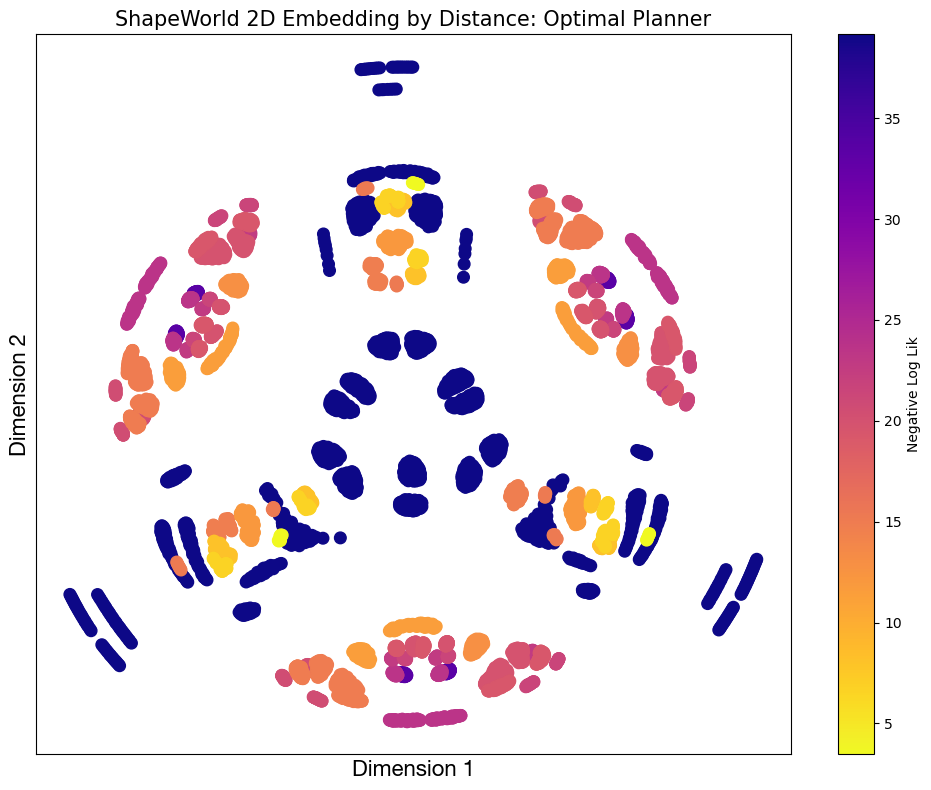

In [34]:
# Plot the state space and the corresponding log likelihoods
optimal_planner.plot_state_space_with_likelihood(is_dark=False, save=False, filename=None)


# PCFG Policy

In [99]:

class PCFGGoalPolicy(GoalSelectionPolicy[State, Action]):
    '''A policy that uses a probabilistic context-free grammar to generate goals.'''

    def __init__(self, mdp: MarkovDecisionProcess[State, Action], p_rules, cap=100):
        super().__init__(mdp)
        self.NON_TERMINALS = [x[0] for x in p_rules]
        self.PRODUCTIONS = {}
        self.CAP = cap
        self.programs = {}
        for rule in p_rules:
            self.PRODUCTIONS[rule[0]] = rule[1]

    def _generate_tree(self, logging=True, tree_str='S', log_prob=0., depth=0):
        '''Use the production rules to generate a possible rule.'''
        current_nt_indices = [tree_str.find(nt) for nt in self.NON_TERMINALS]
        # Sample a non-terminal for generation
        to_gen_idx = sample([idx for idx, el in enumerate(current_nt_indices) if el > -1], 1)[0]
        to_gen_nt = self.NON_TERMINALS[to_gen_idx]
        # Do generation
        leaf = sample(self.PRODUCTIONS[to_gen_nt], 1)[0]
        to_gen_tree_idx = tree_str.find(to_gen_nt)
        tree_str = tree_str[:to_gen_tree_idx] + leaf + tree_str[(to_gen_tree_idx+1):]
        # Update production log prob
        log_prob += log(1/len(self.PRODUCTIONS[to_gen_nt]))
        # Increase depth count
        depth += 1

        # Recursively rewrite string
        if any (nt in tree_str for nt in self.NON_TERMINALS) and depth <= self.CAP:
            return self._generate_tree(logging, tree_str, log_prob, depth)
        elif any (nt in tree_str for nt in self.NON_TERMINALS):
            if logging:
                print('====DEPTH EXCEEDED!====')
            return None
        else:
            if logging:
                print(tree_str, log_prob)
            return tree_str, log_prob
        
    def generate_programs(self, n_iterations=100000) -> pd.DataFrame:
        '''Generate a number of rules.'''
        # reset rules for the object
        self.programs = []

        # generate rules
        for _ in range(n_iterations):
            rule = self._generate_tree(logging=False)
            if rule is not None:
                self.programs.append(rule)

        df = pd.DataFrame(self.programs, columns=['program', 'lp'])

        grouped_df = df.groupby('program')['lp'].mean().reset_index()
        count_df = df['program'].value_counts().reset_index()
        count_df.columns = ['program', 'count']
        result_df = pd.merge(grouped_df, count_df, on='program')
        result_df = result_df.sort_values(by='count', ascending=False).reset_index()
        return result_df

    def extract_arguments(self,args_str):
        '''Naive argument extraction assuming balanced parentheses and simple structure'''
        level = 0
        last_split = 0
        args = []
        for i, char in enumerate(args_str):
            if char == '(':
                level += 1
            elif char == ')':
                level -= 1
            elif char == ',' and level == 0:
                args.append(args_str[last_split:i].strip())
                last_split = i + 1
        args.append(args_str[last_split:].strip())  # Add the last argument
        return args

    def one(*args, state: State) -> bool:
        '''Check the conditions for one shape in the given state based on arguments.'''
        # Remove the self argument
        args = args[1:]

        # One unique feature in the state
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']:
            feature = args[0]
            count = 0
            for shape in (state.shape1, state.shape2, state.shape3):
                if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                    count += 1
            return count == 1

        # Feature and location
        elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain'] and args[1] in ['(0)', '(1)', '(2)']:
            feature, location = args
            location = int(location[1])
            shape = (state.shape1, state.shape2, state.shape3)[location]
            return (feature in shape.sides or feature in shape.shade or feature in shape.texture)
        else:
            raise ValueError('Invalid number of arguments for one shape rule.')

    def two(*args, state) -> bool:
        '''Check the conditions for two shapes in the given state based on arguments.'''
        # Remove the self argument
        args = args[1:]
        # CASE 1 [two(B)]: Two of a feature anywhere
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']:
            feature = args[0]
            count = 0
            for shape in (state.shape1, state.shape2, state.shape3):
                if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                    count += 1
            return count == 2
        
        # CASE 2 [two(F,E)]: Compare two shapes for given number of features
        elif (len(args) == 2) and (args[0] in ['1','2', '3']) and args[1] in ['same', 'unique']:
            feature_count, comparison = args
            feature_count = int(feature_count)
            # Check to see if exactly two shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    common_features = len(features1.intersection(features2))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return matching_pairs == 1
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return non_matching_pairs == 2
                
            else:
                return False

        # CASE 3 [two(E)]: Check to see if any two shapes are the same across all features
        elif len(args) == 1 and args[0] in ['same', 'unique']:
            comparison = args[0]
            feature_count = 3
            # Check to see if exactly two shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    common_features = len(features1.intersection(features2))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return matching_pairs == 1
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return non_matching_pairs == 2
        
        # CASE 4 [two(B,D)]: Compare two locations for one feature
        elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
            feature, location = args
            location1 = int(location[1])
            location2 = int(location[3])
            shape1 = (state.shape1, state.shape2, state.shape3)[location1]
            shape2 = (state.shape1, state.shape2, state.shape3)[location2]
            return (feature in shape1.sides or feature in shape1.shade or feature in shape1.texture) and (feature in shape2.sides or feature in shape2.shade or feature in shape2.texture)

        # CASE 5 [two(D,E)]: Compare two locations across all features
        elif len(args) == 2 and args[0] in ['same','unique'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
            comparison, location = args
            location1 = int(location[1])
            location2 = int(location[3])
            shape1 = (state.shape1, state.shape2, state.shape3)[location1]
            shape2 = (state.shape1, state.shape2, state.shape3)[location2]
            features1 = {shape1.sides, shape1.shade, shape1.texture}
            features2 = {shape2.sides, shape2.shade, shape2.texture}
            if comparison == 'same':
                return len(features1.intersection(features2)) == 3
            elif comparison == 'unique':
                return len(features1.intersection(features2)) == 0
            else:
                raise ValueError('Invalid call for the two shapes rule.')

        else:
            raise ValueError('Invalid call for the two shapes rule.')

    def three(*args, state: State) -> bool:
        '''Check the conditions for all shapes in the given state based on arguments.'''
        
        # Remove the self argument
        args = args[1:]

        # Feature only (assuming 'three' checks for a feature across all shapes, which is not directly specified)
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']:
            feature = args[0]
            return all(feature in shape.sides or feature in shape.shade or feature in shape.texture for shape in (state.shape1, state.shape2, state.shape3))
        
        # Compare three shapes for given number of features
        elif (len(args) == 2) and (args[0] in ['1','2','3']) and args[1] in ['same','unique']:
            feature_count, comparison = args
            feature_count = int(feature_count)
            # Check to see if all three shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_triads = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                    common_features = len(features1.intersection(features2).intersection(features3))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_triads += 1
                # Return True only if exactly one triad matches the criteria
                return matching_triads == 1
            
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_triads = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2).intersection(features3))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_triads += 1
                # Return True only if exactly one triad matches the criteria
                return non_matching_triads == 1

        # TODO: Check logic here
        elif len(args) == 1 and args[0] in ['same', 'unique']:
            feature = args[0]
            features = [shape.sides for shape in (state.shape1, state.shape2, state.shape3)]
            features += [shape.shade for shape in (state.shape1, state.shape2, state.shape3)]
            features += [shape.texture for shape in (state.shape1, state.shape2, state.shape3)]
            unique_features = set(features)
            if feature == 'same':
                return len(unique_features) == 3
            elif feature == 'unique':
                return len(features) == len(unique_features)
            
        # TODO: Add case for checking multiple features

        else:
            raise ValueError('Invalid number of arguments for three shapes rule.')  

    def program_applies(self, program: str, s: State) -> bool:

        # TODO: Refactor to where program implementation do not need to be in class. Maybe a dictionary?

        # recursively unpack nested and statements
        if program.startswith('and'):
            #print(program[4:-1])
            args = self.extract_arguments(program[4:-1])
            # print(f'All arguments: {args}')
            outcome1 = self.program_applies(args[0],s)
            outcome2 = self.program_applies(args[1],s)
            return outcome1 and outcome2  #all(rule_applies(arg, s) for arg in args)
        
        # once the and statements are unpacked, we can evaluate the rules
        elif program.startswith(('one', 'two', 'three')):
            func_name, args_str = program.split('(', 1)
            args = self.extract_arguments(args_str[:-1])  # Remove the closing parenthesis and extract arguments
            func = getattr(self, func_name)  # Dynamically get the method from the class instance
            # print(f'Function: {func_name}, Arguments: {args}')
            return func(*args, state=s)  # Call the method with arguments and state
        
    def likelihood_state_given_program(self, program: str, state: State) -> float:
        '''Calculate the likelihood of a state given a program.'''
        covered_states = {}
        # store the states that apply to the program
        for state in self.state_space:
            if self.program_applies(program, state):
                covered_states[state] = 1
            else:
                return 0
        # calculate the likelihood, assuming all states are equally likely if covered
        likelihood = 1 / len(covered_states)
        return likelihood

    def calc_neg_log_likelihood_state(self, state: State) -> float:
        '''Calculate the negative log likelihood of a state given the grammar.'''
        # marginalize over all programs
        likelihood = 0
        for rules in self.programs:
            likelihood_program = np.exp(rules[1]) # given the grammar
            likelihood_state = self.likelihood_state_given_program(rules[0], state)
            likelihood += likelihood_program * likelihood_state
        return -1 * np.log(likelihood)

    def calculate_neg_log_likelihood_all_df(self) -> pd.DataFrame:
        '''Calculate the log likelihood of all states given produced rules.'''
        # check to make sure we have rules
        if len(self.programs) == 0:
            raise ValueError('No rules have been generated yet!')
        
        # iterate through all states and calculate the log likelihood
        neg_log_likelihoods = {}

        # loop through each state and rule
        for state in self.state_space:
            neg_log_likelihoods[state] = self.calc_neg_log_likelihood_state(state)

        # return the negative log likelihood for each state
        return neg_log_likelihoods

    def _get_programs(self) -> dict[str, list[str]]:
        return self.programs
    
    def _get_programs_df(self) -> pd.DataFrame:
        # put the rules in a dataframe
        df = pd.DataFrame(self.programs, columns=['program', 'lp'])
        grouped_df = df.groupby('program')['lp'].mean().reset_index()
        count_df = df['program'].value_counts().reset_index()
        count_df.columns = ['program', 'count']
        result_df = pd.merge(grouped_df, count_df, on='program')
        result_df = result_df.sort_values(by='lp', ascending=False).reset_index()
        return result_df

# Trying out a new PCFG

In [102]:
# let's try a different grammar
'''
With this grammar, we cover all cases of 1,2, and 3 shapes being compared. 

But importantly, we formalize location and feature symmetry.
Location symmetry arises because the transition function between features is location agnostic.
That is, two(feature) is agnostic to the locations of the features.
Feature symmetry arises because relations between locations are feature agnostic.
That is, same(a,b) can be applied to all features. 
Thus, if people are reusing transition knowledge we might expect them to set goals using location symmetry.
If people are reusing program formulations, we might expect them to set goals using feature symmetry.
'''
productions2 = [
  ['S', ['and(S,S)', 'A']], # allow conjunctions
  ['A', ['one(B)', 'two(B)', 'three(B)', # location symmetry, fix one feature (location agnostic, compare feature)
         'two(E)', 'three(E)', # location symetry, feature symmetry (location agnostic, feature agnostic)
         'two(F,E)', 'three(F,E)', # location symmetry, multiple feature symetry (location agnostic, feature agnostic)
         'one(B,C)', 'two(B,D)', # feature in location, specify feature (location given, feature compare)
         'two(E,D)'# give location, feature symmetry (location given, feature agnostic)
         ]],
  ['B', ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']], # features
  ['C', ['(0)', '(1)', '(2)']], # locations
  ['D', ['(0,1)', '(0,2)', '(1,2)']], # diad locations
  ['E', ['same','unique']], # relation,
  ['F', ['1','2','3']], # number of features to compare
]

# instantiate the goal space
goal_world_pcfg = GoalWorld()
pcfg_policy = PCFGGoalPolicy(mdp=goal_world_pcfg, p_rules=productions2, cap=100)
pcfg_programs = pcfg_policy.generate_programs(100000)


In [103]:
'''Testing `calculate_neg_log_likelihood_all_df`'''
# TODO: Add tqdm for progress bar
pcfg_state_neg_loglik = pcfg_policy.calculate_neg_log_likelihood_all_df()

/var/folders/qr/gb70fn114p97s4wfdyrjqlv40000gp/T/ipykernel_24817/779373622.py:306: RuntimeWarning: divide by zero encountered in log
  return -1 * np.log(likelihood)


In [101]:
'''Testing program_applies()'''
program = 'one(square)'
shape1 = Shape(sides='square', shade='low', texture='striped')
shape2 = Shape(sides='circle', shade='medium', texture='plain')
shape3 = Shape(sides='triangle', shade='high', texture='striped')
state = State(shape1, shape2, shape3)
try:
    assert pcfg_policy.program_applies(program, state) == True
except AssertionError as e:
    raise AssertionError("Does contain one square: " + str(e))

program = 'two(square)'
shape1 = Shape(sides='square', shade='low', texture='striped')
shape2 = Shape(sides='circle', shade='medium', texture='plain')
shape3 = Shape(sides='triangle', shade='high', texture='striped')
state = State(shape1, shape2, shape3)
try:
    assert pcfg_policy.program_applies(program, state) == False
except AssertionError as e:
    raise AssertionError("Does contain one square: " + str(e))

program = 'two(1,same)'
shape1 = Shape(sides='square', shade='low', texture='striped')
shape2 = Shape(sides='square', shade='medium', texture='plain')
shape3 = Shape(sides='triangle', shade='high', texture='dots')
state = State(shape1, shape2, shape3)
try:
    assert pcfg_policy.program_applies(program, state) == True
except AssertionError as e:
    raise AssertionError("Does contain one square: " + str(e))

print('All tests passed!')

All tests passed!


# Linking the programs to the state space

In [54]:

def program_applies(program: str, s: State) -> bool:
    '''Check if a program applies to a state.'''
    def extract_arguments(args_str):
        '''Naive argument extraction assuming balanced parentheses and simple structure'''
        level = 0
        last_split = 0
        args = []
        for i, char in enumerate(args_str):
            if char == '(':
                level += 1
            elif char == ')':
                level -= 1
            elif char == ',' and level == 0:
                args.append(args_str[last_split:i].strip())
                last_split = i + 1
        args.append(args_str[last_split:].strip())  # Add the last argument
        return args

    def one(*args, state: State) -> bool:
        '''Check the conditions for one shape in the given state based on arguments.'''

        # One unique feature in the state
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']:
            feature = args[0]
            count = 0
            for shape in (state.shape1, state.shape2, state.shape3):
                if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                    count += 1
            return count == 1

        # Feature and location
        elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain'] and args[1] in ['(0)', '(1)', '(2)']:
            feature, location = args
            location = int(location[1])
            shape = (state.shape1, state.shape2, state.shape3)[location]
            return (feature in shape.sides or feature in shape.shade or feature in shape.texture)
        else:
            raise ValueError('Invalid number of arguments for one shape rule.')

    def two(*args, state) -> bool:
        '''Check the conditions for two shapes in the given state based on arguments.'''

        # CASE 1 [two(B)]: Two of a feature anywhere
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']:
            feature = args[0]
            count = 0
            for shape in (state.shape1, state.shape2, state.shape3):
                if (feature in shape.sides or feature in shape.shade or feature in shape.texture):
                    count += 1
            return count == 2
        
        # CASE 2 [two(F,E)]: Compare two shapes for given number of features
        elif (len(args) == 2) and (args[0] in ['1','2', '3']) and args[1] in ['same', 'unique']:
            feature_count, comparison = args
            feature_count = int(feature_count)
            # Check to see if exactly two shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    common_features = len(features1.intersection(features2))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return matching_pairs == 1
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return non_matching_pairs == 2
                
            else:
                return False

        # CASE 3 [two(E)]: Check to see if any two shapes are the same across all features
        elif len(args) == 1 and args[0] in ['same', 'unique']:
            comparison = args[0]
            feature_count = 3
            # Check to see if exactly two shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    common_features = len(features1.intersection(features2))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return matching_pairs == 1
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_pairs = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 2):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_pairs += 1
                # Return True only if exactly one pair matches the criteria
                return non_matching_pairs == 2
        
        # CASE 4 [two(B,D)]: Compare two locations for one feature
        elif len(args) == 2 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
            feature, location = args
            location1 = int(location[1])
            location2 = int(location[3])
            shape1 = (state.shape1, state.shape2, state.shape3)[location1]
            shape2 = (state.shape1, state.shape2, state.shape3)[location2]
            return (feature in shape1.sides or feature in shape1.shade or feature in shape1.texture) and (feature in shape2.sides or feature in shape2.shade or feature in shape2.texture)

        # CASE 5 [two(D,E)]: Compare two locations across all features
        elif len(args) == 2 and args[0] in ['same','unique'] and args[1] in ['(0,1)', '(0,2)', '(1,2)']:
            comparison, location = args
            location1 = int(location[1])
            location2 = int(location[3])
            shape1 = (state.shape1, state.shape2, state.shape3)[location1]
            shape2 = (state.shape1, state.shape2, state.shape3)[location2]
            features1 = {shape1.sides, shape1.shade, shape1.texture}
            features2 = {shape2.sides, shape2.shade, shape2.texture}
            if comparison == 'same':
                return len(features1.intersection(features2)) == 3
            elif comparison == 'unique':
                return len(features1.intersection(features2)) == 0
            else:
                raise ValueError('Invalid call for the two shapes rule.')

        else:
            raise ValueError('Invalid call for the two shapes rule.')

    def three(*args, state: State) -> bool:
        '''Check the conditions for all shapes in the given state based on arguments.'''
        # This function is similar to `one` and `two`, but checks for conditions applying to all three shapes.
        # Since the provided PCFG does not specify a 'three' function directly, we'll assume it's meant to check
        # if all shapes meet a certain condition, which is not directly applicable with the given rules.
        # For demonstration, let's assume it checks if all shapes have a specific feature, though this might not be
        # directly applicable or meaningful with the given PCFG structure and needs to be adjusted based on actual requirements.

        # Feature only (assuming 'three' checks for a feature across all shapes, which is not directly specified)
        if len(args) == 1 and args[0] in ['square', 'circle', 'triangle', 'low', 'medium', 'high', 'striped', 'plain']:
            feature = args[0]
            return all(feature in shape.sides or feature in shape.shade or feature in shape.texture for shape in (state.shape1, state.shape2, state.shape3))
        
        # Compare three shapes for given number of features
        elif (len(args) == 2) and (args[0] in ['1','2','3']) and args[1] in ['same','unique']:
            feature_count, comparison = args
            feature_count = int(feature_count)
            # Check to see if all three shapes share the specified number of features, and no more
            if comparison == 'same':
                matching_triads = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                    common_features = len(features1.intersection(features2).intersection(features3))
                    # Check if the number of common features matches the specified count
                    if common_features == feature_count:
                        matching_triads += 1
                # Return True only if exactly one triad matches the criteria
                return matching_triads == 1
            
            # Check over specified number of features, if shapes are unique
            elif comparison == 'unique':
                MAX_NUM_FEATURES = 3
                non_matching_triads = 0
                for shape_combo in combinations([state.shape1, state.shape2, state.shape3], 3):
                    features1 = {shape_combo[0].sides, shape_combo[0].shade, shape_combo[0].texture}
                    features2 = {shape_combo[1].sides, shape_combo[1].shade, shape_combo[1].texture}
                    features3 = {shape_combo[2].sides, shape_combo[2].shade, shape_combo[2].texture}
                    num_unique_features = MAX_NUM_FEATURES - len(features1.intersection(features2).intersection(features3))
                    # Check if the number of common features exceeds the specified count
                    if num_unique_features == feature_count:
                        non_matching_triads += 1
                # Return True only if exactly one triad matches the criteria
                return non_matching_triads == 1

        # TODO: Check logic here
        elif len(args) == 1 and args[0] in ['same', 'unique']:
            feature = args[0]
            features = [shape.sides for shape in (state.shape1, state.shape2, state.shape3)]
            features += [shape.shade for shape in (state.shape1, state.shape2, state.shape3)]
            features += [shape.texture for shape in (state.shape1, state.shape2, state.shape3)]
            unique_features = set(features)
            if feature == 'same':
                return len(unique_features) == 3
            elif feature == 'unique':
                return len(features) == len(unique_features)
            
        # TODO: Add case for checking multiple features

        else:
            raise ValueError('Invalid number of arguments for three shapes rule.')  

    # recursively unpack nested and statements
    if program.startswith('and'):
        args = extract_arguments(program[4:-1])
        print(f'All arguments: {args}')
        outcome1 = program_applies(args[0],s)
        outcome2 = program_applies(args[1],s)
        return outcome1 and outcome2  #all(rule_applies(arg, s) for arg in args)
    
    # once the and statements are unpacked, we can evaluate the rules
    elif program.startswith(('one', 'two', 'three')):
        func_name, args_str = program.split('(', 1)
        args = extract_arguments(args_str[:-1])  # Remove the closing parenthesis and extract arguments
        func = globals()[func_name]  # Dynamically get the function based on its name
        
        return func(*args, state=s)
    

# Write Log Lik Function For Goal States

In [55]:

def likelihood_state_given_program(program: str, state: State) -> float:
    '''Calculate the likelihood of a state given a program.'''
    covered_states = {}
    # store the states that apply to the program
    for state in self.state_space:
        if program_applies(program, state):
            covered_states[state] = 1
    # calculate the likelihood, assuming all states are equally likely if covered
    likelihood = 1 / len(covered_states)
    return likelihood


# For each state, check if the program applies. Then store only the program with the highest likelihood.
def calculate_neg_log_likelihood_all_df(self) -> pd.DataFrame:
    '''Calculate the log likelihood of all states given produced rules.'''
    # check to make sure we have rules
    if len(self.programs) == 0:
        raise ValueError('No rules have been generated yet!')
    
    # iterate through all states and calculate the log likelihood
    likelihoods = {}

    # loop through each state and rule
    for state in self.state_space:
        likelihood = 0
        # Check if the rule applies to the state
        for rule in self.programs:
            # first index has the rule, second index has the log likelihood
            if program_applies(rule[0], state):
                # convert to likelihood
                likelihood_program = np.exp(rule[1]) # given the grammar
                likelihood_state = likelihood_state_given_program(rule[0], state)
                likelihood += likelihood_program * likelihood_state

        likelihoods[state] = likelihood

    # return the negative log likelihood for each state
    return -1 * np.log(likelihoods)

# TODO: Add the function to the class




# Tests

# Original PCFG

In [ ]:
# instantiate the goal space
goal_world_pcfg = GoalWorld()

# the rules of the grammar
productions = [
  ['S', ['and(S,S)', 'A']],
  ['A', ['same(B,C)', 'unique(B,C)']],
  ['B', ['everything', 'D', 'E']],
  ['C', ['true', 'color', 'shape', 'texture', 'false']],
  ['D', ['one', 'G']],
  ['E', ['two', 'H']],
  ['F', ['square', 'circle', 'triangle', 'light', 'medium', 'dark', 'plain', 'stripe']],
  ['G', ['a', 'b', 'c']], # location on the screen
  ['H', ['ab', 'ac', 'bc']],
]

pcfg_policy = PCFGGoalPolicy(mdp=goal_world_pcfg, p_rules=productions, cap=100)
pcfg_ll = pcfg_policy.generate_rules(100000)